Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Stable Signature - Decoding

Each model has its own key, which can be found in the `keys.txt` file when the fine-tuning is done. 
The key is a string of 48 bits, which can be converted to a boolean array of 48 elements. 
The `msg_extractor` is a TorchScript model that extracts the message from the image.

Based on the number of matching bits between the key and the message, the image can be classified as genuine or generated by our model.

### Imports and setup

In [6]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def msg2str(msg):
    return "".join([('1' if el else '0') for el in msg])

def str2msg(str):
    return [True if el=='1' else False for el in str]

msg_extractor = torch.jit.load("path/to/dec_48b_whit.torchscript.pt").to("cuda")
transform_imnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

### Decode images

In [29]:
img = Image.open("path/to/generated/img.png")
img = transform_imnet(img).unsqueeze(0).to("cuda")
msg = msg_extractor(img) # b c h w -> b k
bool_msg = (msg>0).squeeze().cpu().numpy().tolist()
print("Extracted message: ", msg2str(bool_msg))

Extracted message:  111010110101000001010111010011010100010000100111


### Compute bit accuracies and run statistical test

Metrics are:
- **Bit accuracy**: number of matching bits between the key and the message, divided by the total number of bits.
- **$p$-value**: probability of observing a bit accuracy as high as the one observed, assuming the null hypothesis that the image is genuine.

In [11]:
key = '111010110101000001010111010011010100010000100111' # model key
bool_key = str2msg(key)

# compute difference between model key and message extracted from image
diff = [bool_msg[i] != bool_key[i] for i in range(len(bool_msg))]
bit_acc = 1 - sum(diff)/len(diff)
print("Bit accuracy: ", bit_acc)

# compute p-value
from scipy.stats import binomtest
pval = binomtest(len(diff)-sum(diff), len(diff), 0.5, alternative='greater')
print("p-value of statistical test: ", pval)

Bit accuracy:  1.0
p-value of statistical test:  BinomTestResult(k=48, n=48, alternative='greater', statistic=1.0, pvalue=3.552713678800501e-15)


Typically, one can set a threshold $\tau$ on the bit accuracy to classify an image as genuine or generated.
Here is the table of FPRs for different thresholds on bit accuracy.

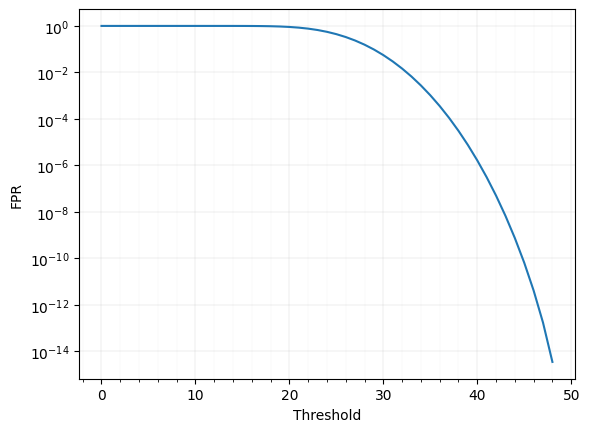

In [27]:
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

def fpr(threshold, n):
    return binom.cdf(n-threshold, n, 0.5)

thresholds = np.linspace(0, 48, 49)
fprs = [fpr(threshold, 48) for threshold in thresholds]

plt.plot(thresholds, fprs)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("FPR")

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.2, alpha=0.8)
plt.grid(axis='both', which='minor', linestyle='-', linewidth=0.1, alpha=0.5)

plt.show()